# 使用PYNQ+vitis hls+ vivado实现将三通道rgb图片转换为单通道灰度图片

# 软件部分

step 01: 导入所需的库 这里我们导入了cv2，numpy和matplotlib.pyplot三个库，分别用于图像处理，数值计算和绘图。

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

step 02:读取图像并显示尺寸 我们使用cv2.imread函数来读取一张logo图片，并使用print函数来显示它的尺寸。注意，cv2读取的图像是以BGR格式存储的，而不是RGB格式。

In [2]:
img = cv2.imread("./logo.png")
print("原始图像尺寸：{}".format(img.shape))

原始图像尺寸：(397, 892, 3)


step 03:使用cv2库将图像转换为灰度图并计时 我们使用cv2.cvtColor函数来将BGR格式的图像转换为灰度图。我们也使用print函数来显示灰度图的尺寸。

In [3]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray

array([[ 34,  35,  35, ..., 105, 105, 104],
       [ 35,  35,  35, ..., 106, 105, 105],
       [ 35,  35,  35, ..., 107, 106, 105],
       ..., 
       [  1,   1,   0, ...,   1,   0,   0],
       [  0,   1,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)

step 04:使用pynq框架加载硬件加速器并分配缓冲区 我们使用pynq.Overlay类来加载一个预先编译好的bitstream文件，该文件包含了一个硬件加速器，用于将RGB格式的图像转换为灰度图。我们使用pynq.allocate函数来分配两个缓冲区，一个用于存储输入的RGB图像，一个用于存储输出的灰度图。我们使用np.copyto函数来将原始图像的数据复制到输入缓冲区中。

In [4]:
from pynq import Overlay, allocate
rows, cols,wid= img.shape
overlay = Overlay("./design_1.bit")
rgb2gray = overlay.rgb2gray_top_0
input_buffer = allocate(shape=(rows*cols*3,), dtype='u1')
output_buffer = allocate(shape=(rows*cols,), dtype='u1')

np.copyto(input_buffer, img.flatten())
input_buffer

PynqBuffer([152,  25,   8, ...,   0,   0,   0], dtype=uint8)

step 05:设置硬件加速器的参数并启动 我们使用write方法来向硬件加速器写入两个参数，分别是图像的行数和列数。这些参数是必须的，因为硬件加速器需要知道输入和输出缓冲区的大小。

In [5]:
rgb2gray.write(0x10, rows)
rgb2gray.write(0x18, cols)

step 06: 查看硬件加速器的寄存器映射 我们使用register_map属性来查看硬件加速器的寄存器映射，可以看到它有四个寄存器，分别是AP_CTRL，ROWS，COLS和AP_RETURN。其中，AP_CTRL是用于控制硬件加速器的启动和停止的，ROWS和COLS是用于设置图像的行数和列数的，AP_RETURN是用于返回硬件加速器的状态和结果的

In [6]:
rgb2gray.register_map

RegisterMap {
  CTRL = Register(AP_START=0, AP_DONE=0, AP_IDLE=1, AP_READY=0, RESERVED_1=0, AUTO_RESTART=0, RESERVED_2=0, INTERRUPT=0, RESERVED_3=0),
  GIER = Register(Enable=0, RESERVED=0),
  IP_IER = Register(CHAN0_INT_EN=0, CHAN1_INT_EN=0, RESERVED_0=0),
  IP_ISR = Register(CHAN0_INT_ST=0, CHAN1_INT_ST=0, RESERVED_0=0),
  rows = Register(rows=397),
  cols = Register(cols=892)
}

step 07:查看DMA控制器的寄存器映射 我们使用overlay.axi_dma_0来获取DMA控制器的实例，并使用register_map属性来查看它的寄存器映射，可以看到它有两个通道，分别是发送通道和接收通道。发送通道用于将输入缓冲区中的数据发送到硬件加速器，接收通道用于将硬件加速器输出的数据接收到输出缓冲区中。

In [7]:
dma = overlay.axi_dma_0
dma.register_map

RegisterMap {
  MM2S_DMACR = Register(RS=1, Reset=0, Keyhole=0, Cyclic_BD_Enable=0, IOC_IrqEn=0, Dly_IrqEn=0, Err_IrqEn=0, IRQThreshold=1, IRQDelay=0),
  MM2S_DMASR = Register(Halted=0, Idle=0, SGIncld=0, DMAIntErr=0, DMASlvErr=0, DMADecErr=0, SGIntErr=0, SGSlvErr=0, SGDecErr=0, IOC_Irq=0, Dly_Irq=0, Err_Irq=0, IRQThresholdSts=0, IRQDelaySts=0),
  MM2S_CURDESC = Register(Current_Descriptor_Pointer=0),
  MM2S_CURDESC_MSB = Register(Current_Descriptor_Pointer=0),
  MM2S_TAILDESC = Register(Tail_Descriptor_Pointer=0),
  MM2S_TAILDESC_MSB = Register(Tail_Descriptor_Pointer=0),
  MM2S_SA = Register(Source_Address=0),
  MM2S_SA_MSB = Register(Source_Address=0),
  MM2S_LENGTH = Register(Length=0),
  SG_CTL = Register(SG_CACHE=0, SG_USER=0),
  S2MM_DMACR = Register(RS=1, Reset=0, Keyhole=0, Cyclic_BD_Enable=0, IOC_IrqEn=0, Dly_IrqEn=0, Err_IrqEn=0, IRQThreshold=1, IRQDelay=0),
  S2MM_DMASR = Register(Halted=0, Idle=0, SGIncld=0, DMAIntErr=0, DMASlvErr=0, DMADecErr=0, SGIntErr=0, SGSlvErr=0, SG

step 08:启动硬件加速器并传输数据 我们使用write方法来向AP_CTRL寄存器写入1，表示启动硬件加速器。然后，我们使用transfer方法来分别向发送通道和接收通道传输输入缓冲区和输出缓冲区。这两个方法都是异步的，也就是说，它们不会等待传输完成就返回。

In [8]:
rgb2gray.write(0x00, 1)
dma.sendchannel.transfer(input_buffer)
dma.recvchannel.transfer(output_buffer)

step 09:显示输出缓冲区中的灰度图 我们使用plt.imshow函数来显示输出缓冲区中的灰度图，注意，我们需要将输出缓冲区重新整形为二维数组，并指定颜色映射为灰度。我们可以看到，输出缓冲区中的灰度图与使用cv2库转换得到的灰度图相同。

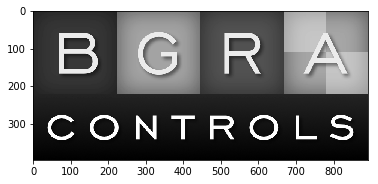

In [9]:
plt.imshow(output_buffer.reshape(rows, cols),cmap='gray')

# 硬件部分

Vitis HLS：进行c仿真,使用的激励源文件为data.txt

![hls_csim](./csim_pixel1.png)

![hls_csim2](./csim_pixel2.png)

Vitis HLS+VIVADO:进行C/RTL Cosimulation

IP核在完成数据处理并发送后成功发送dst_TLAST信号，标志已完成处理

![hls_cosim](./cosim_wave1.png)

testbench以B、G、R的顺序向IP核发送图片的像素数据,因此src_TVALID保持置1并以1,1,255,1,1,255的顺序通过src流发送像素数据。而IP核接受src流的数据并以B、G、R的顺序完成读取src、处理像素、写入dst流的过程。在波形图中我们可以看出，IP核随着src的写入同步进行处理，这是因为我们使用src.read()进行阻塞性的读取，当src流未被填充,IP核就会停止在读取步骤直至可以读取。此外,根据dst_TVALID我们可以看出，只有当dst_TVALID拉高时dst_DATA输出的数据才有效，因此，实际输出的有效值皆为4d也就是77,符合gray=0.299*r+0.578*g+0.114*b 的计算

![hls_cosim](./cosim_wave2.png)

Vitis HLS: export RTL,这时我们可以查看IP核最终的资源占用量

![export_report](./export _report.png)

VIVADO:进行block design,输出hwh和bit流文件。最终将hwh和bit流文件上传至jupyter notebook

![vivado_blockdesign](./vivado_blockdesign.jpg)

![implement_report](./implemen_report.png)